In [24]:
# %%
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, Input, Flatten, Dense, Reshape,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

game_mode = {
    "test": {"rows": 5, "columns": 5, "mines": 2},
    "easy": {"rows": 10, "columns": 10, "mines": 10},
    "intermediate": {"rows": 16, "columns": 16, "mines": 40},
    "hard": {"rows": 16, "columns": 40, "mines": 99},
}
mode = 'easy'
N = game_mode[mode]["rows"]
M = game_mode[mode]["columns"]

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 64
LR = 0.001



In [25]:
DATASET_DIR = "/kaggle/input/mn-nn-ez/minesweeper_dataset_easy_2048"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")


def load_npz_files_from_dir(directory):
    """Load all .npz files from a directory into NumPy arrays."""
    inputs, labels = [], []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith(".npz"):
            data = np.load(os.path.join(directory, file_name))
            inputs.append(data["input"])  # shape (N, M)
            labels.append(data["label"])  # shape (N, M)
    return np.array(inputs), np.array(labels)

In [26]:
print("Loading dataset...")
train_boards, train_labels = load_npz_files_from_dir(TRAIN_DIR)
val_boards,   val_labels   = load_npz_files_from_dir(VAL_DIR)
test_boards,  test_labels  = load_npz_files_from_dir(TEST_DIR)

print(f"Train set: {train_boards.shape}, {train_labels.shape}")
print(f"Validation set: {val_boards.shape}, {val_labels.shape}")
print(f"Test set: {test_boards.shape}, {test_labels.shape}")

# Expand dims for CNN (N, M) -> (N, M, 1)
train_boards = np.expand_dims(train_boards, axis=-1)  # (num_samples, N, M, 1)
val_boards   = np.expand_dims(val_boards,   axis=-1)
test_boards  = np.expand_dims(test_boards,  axis=-1)

# Expand dims in labels as well
train_labels = np.expand_dims(train_labels, axis=-1)  # (num_samples, N, M, 1)
val_labels   = np.expand_dims(val_labels,   axis=-1)
test_labels  = np.expand_dims(test_labels,  axis=-1)

Loading dataset...
Train set: (20527, 10, 10), (20527, 10, 10)
Validation set: (6842, 10, 10), (6842, 10, 10)
Test set: (6843, 10, 10), (6843, 10, 10)


In [27]:
def create_tf_dataset(inputs, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(inputs))
    return dataset.batch(batch_size)

train_dataset = create_tf_dataset(train_boards, train_labels, BATCH_SIZE)
val_dataset   = create_tf_dataset(val_boards,   val_labels,   BATCH_SIZE)
test_dataset  = create_tf_dataset(test_boards,  test_labels,  BATCH_SIZE)

In [37]:
def create_minesweeper_cnn(input_shape=(8, 8, 1), lr=0.001):
    """
    A simple single-input CNN that:
      - Takes board input of shape (N, M, 1).
      - Outputs (N, M, 1) probabilities (sigmoid).
    """
    model = models.Sequential([
        # Input layer: shape (10, 10, 1)
        layers.Input(shape=(N, M, 1)),
        
        # Conv2D layers
        layers.Conv2D(100, kernel_size=3, padding='same', activation='sigmoid', name='conv2d_5'),
        layers.Conv2D(50, kernel_size=3, padding='same', activation='sigmoid', name='conv2d_6'),
        layers.Conv2D(25, kernel_size=3, padding='same', activation='sigmoid', name='conv2d_7'),
        layers.Conv2D(16, kernel_size=3, padding='same', activation='sigmoid', name='conv2d_8'),
        layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='conv2d_9')
    ])
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', 'mean_absolute_error']  
    )
    return model

model = create_minesweeper_cnn(input_shape=(N, M, 1), lr=LR)

In [38]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 10, 10, 100)         │           1,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 10, 10, 50)          │          45,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 25)          │          11,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 10, 16)          │           3,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,086 (238.62 KB)

 Trainable params: 61,086 (238.62 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
print("Training the model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

print("Evaluating on the test set...")
test_loss, test_accuracy, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test MAE: {test_mae:.4f}")

Training the model...
Epoch 1/64
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7942 - loss: 0.3077 - mean_absolute_error: 0.1598 - val_accuracy: 0.8516 - val_loss: 0.1130 - val_mean_absolute_error: 0.0546
Epoch 2/64
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8582 - loss: 0.0937 - mean_absolute_error: 0.0407 - val_accuracy: 0.8646 - val_loss: 0.0733 - val_mean_absolute_error: 0.0253
Epoch 3/64
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8648 - loss: 0.0696 - mean_absolute_error: 0.0226 - val_accuracy: 0.8685 - val_loss: 0.0640 - val_mean_absolute_error: 0.0183
Epoch 4/64
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8722 - loss: 0.0603 - mean_absolute_error: 0.0170 - val_accuracy: 0.8700 - val_loss: 0.0598 - val_mean_absolute_error: 0.0169
Epoch 5/64
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8745 - loss: 0.0565 - mean_absolute_error: 0.0143 - val_accuracy: 0.8707 - val_loss: 0.0581 - val_mean_absolute_error: 0.0162
Epoch 6/

In [40]:
MODEL_PATH = "/kaggle/working/minesweeper_model.h5"
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /kaggle/working/minesweeper_model.h5


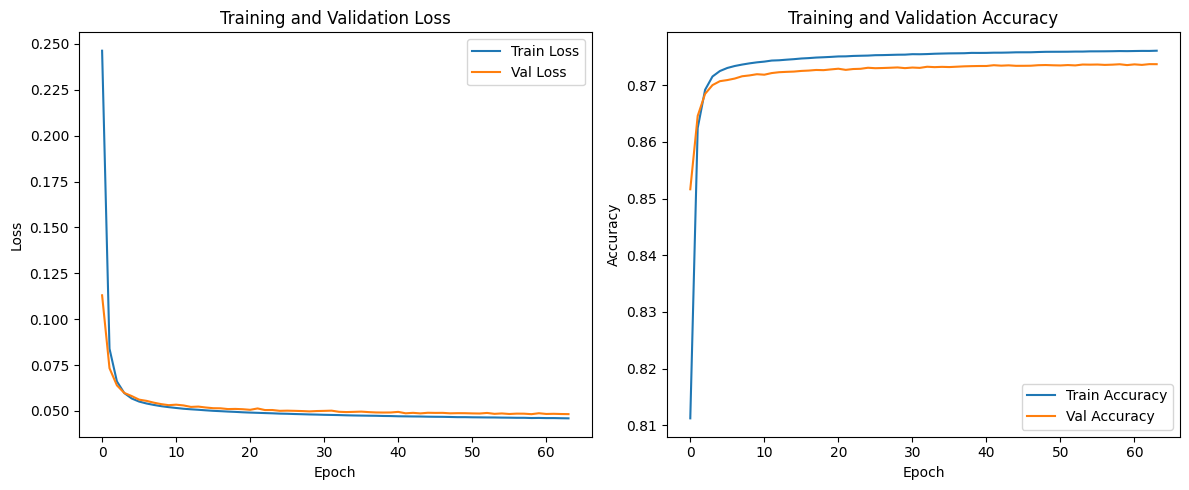

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Visual comparison of Label (Bayes) vs. NN Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


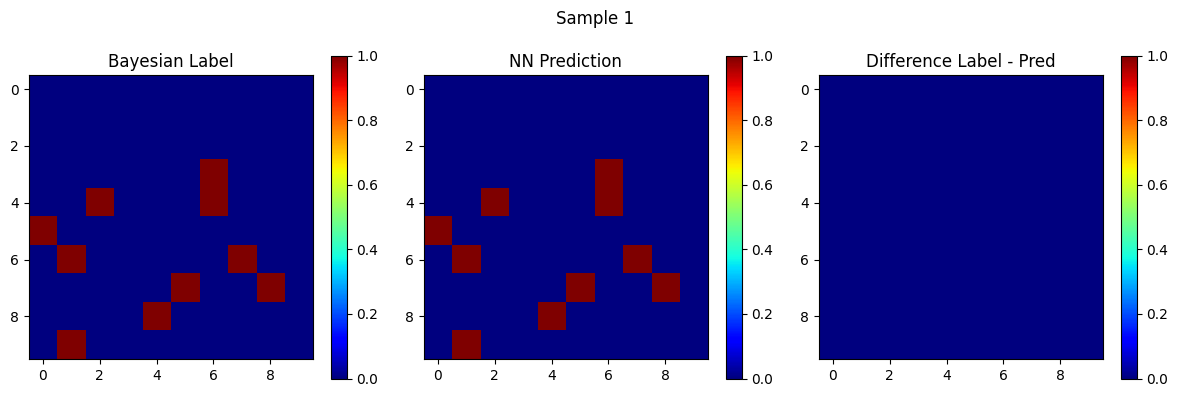

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


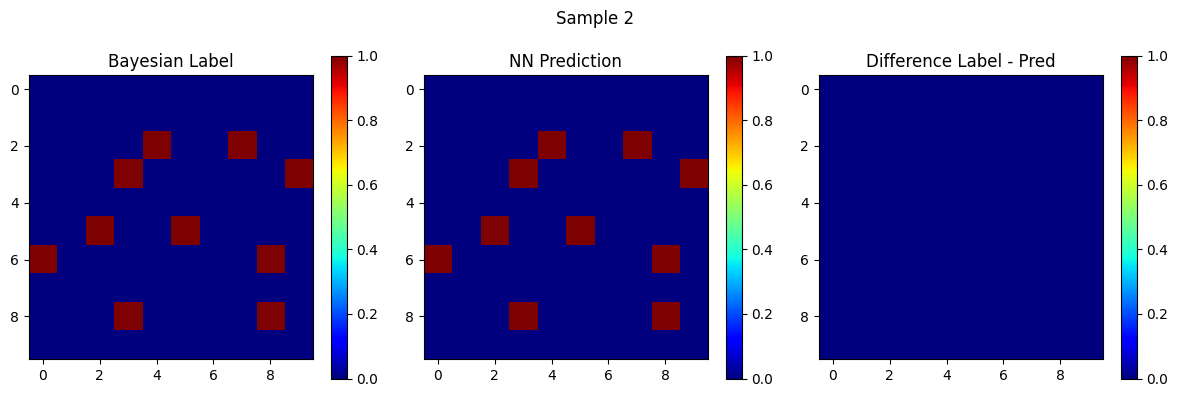

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


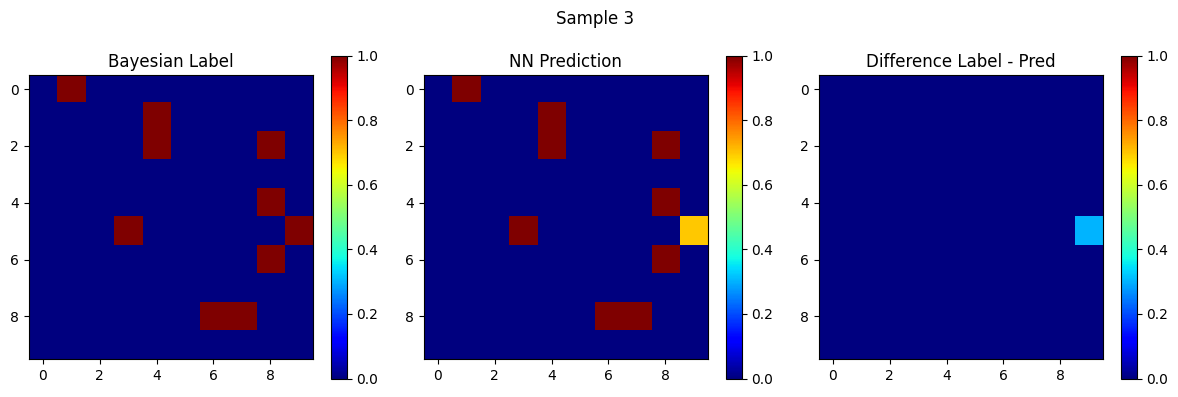

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


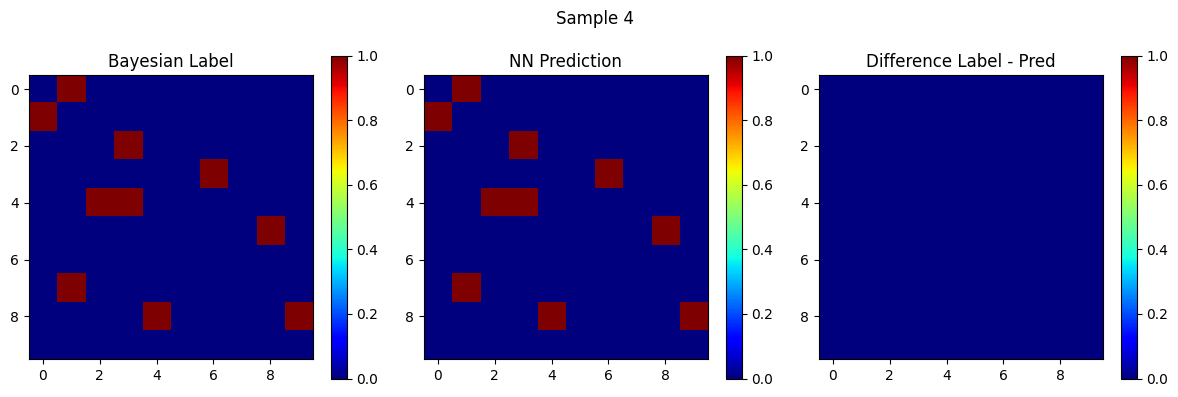

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


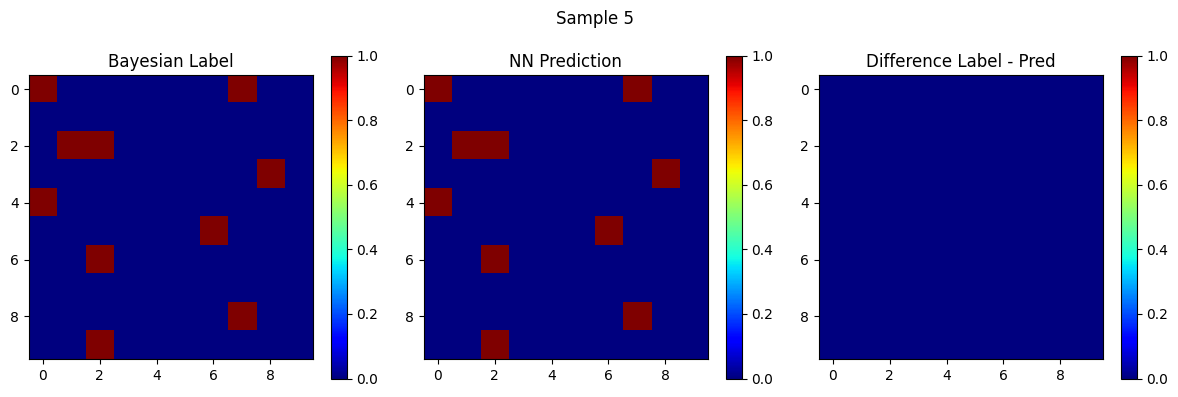

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


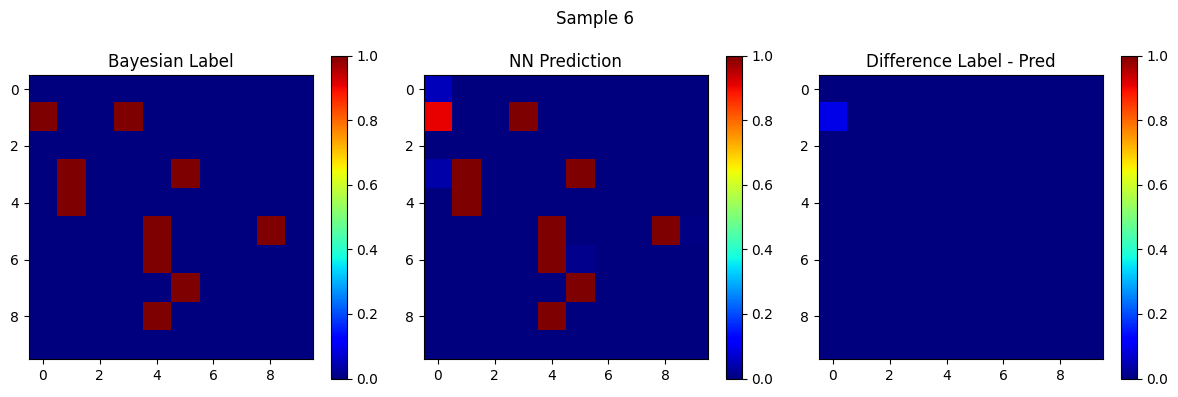

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


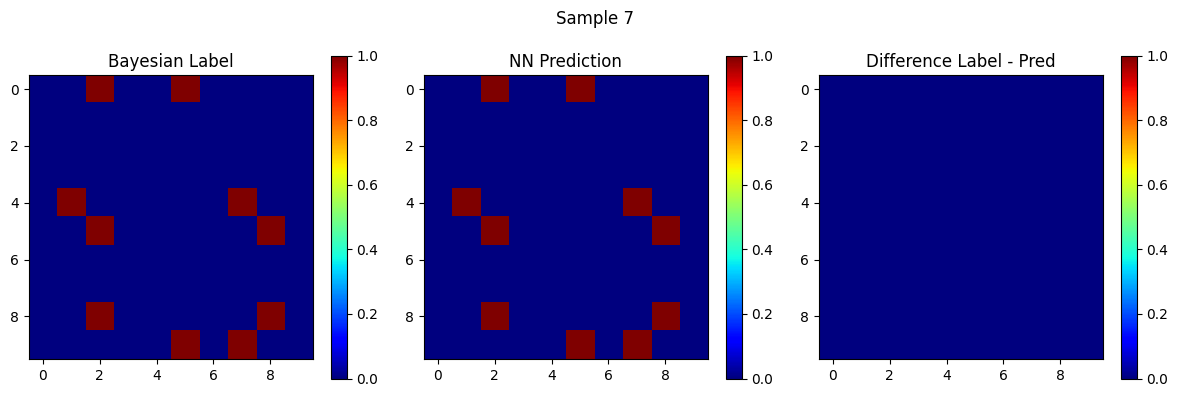

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


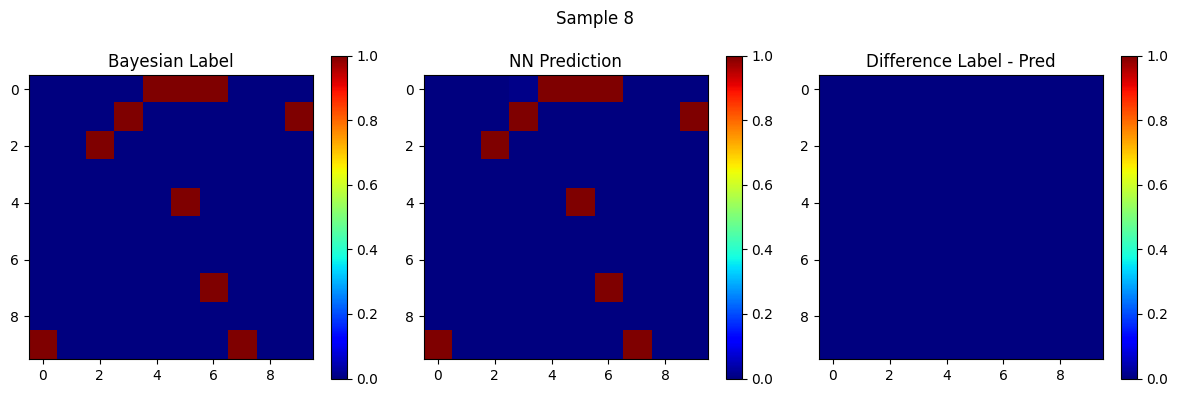

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


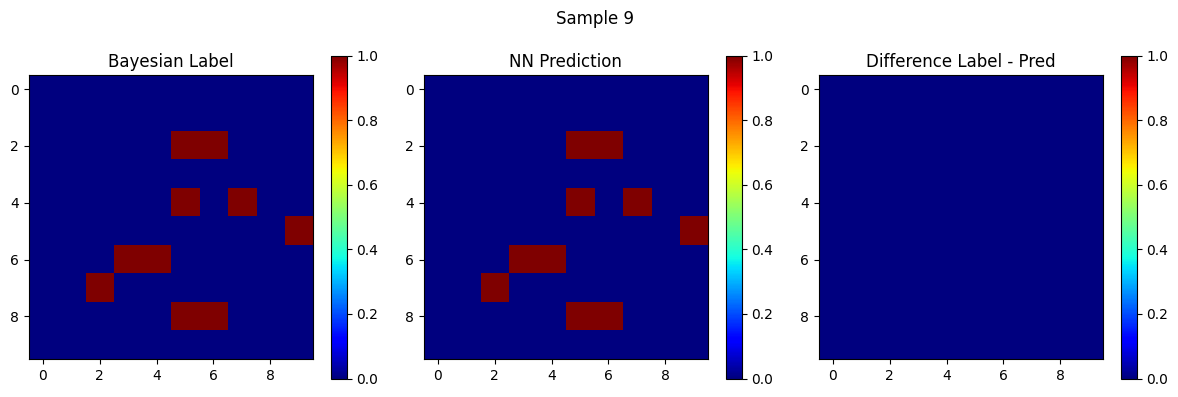

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


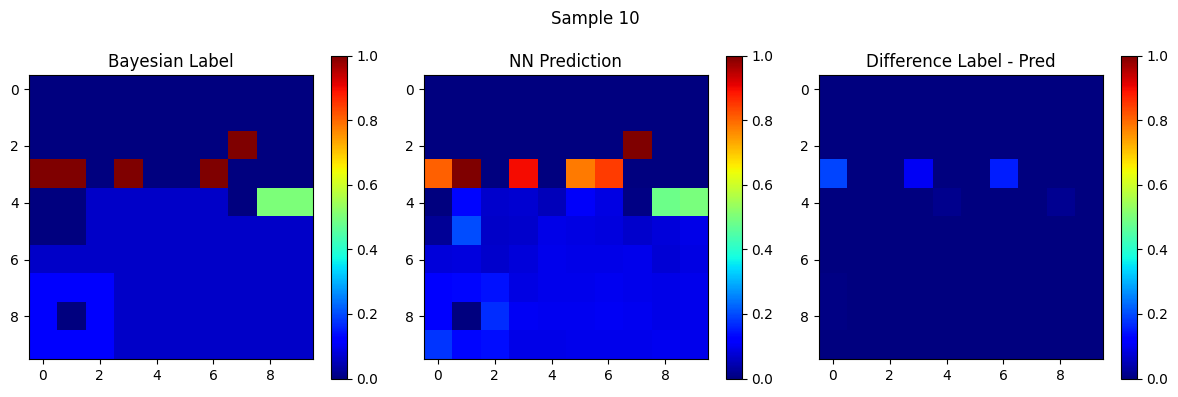

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


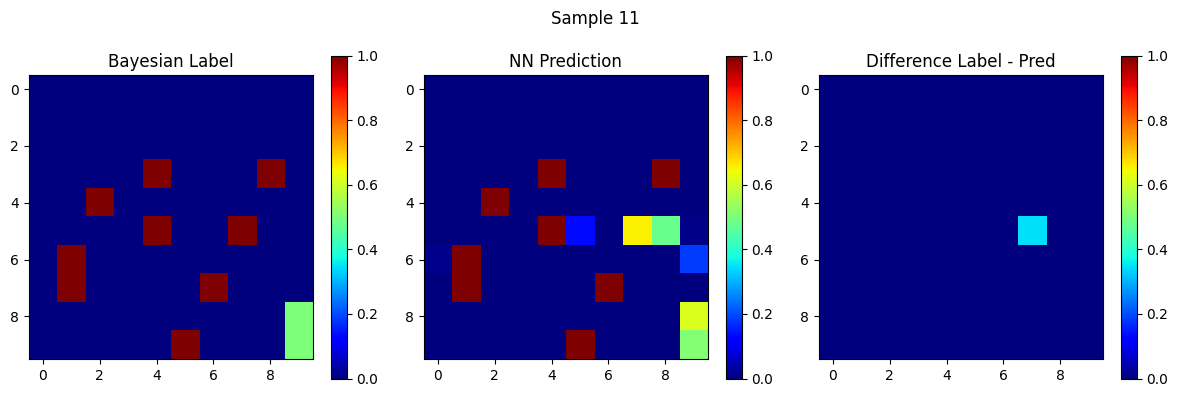

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


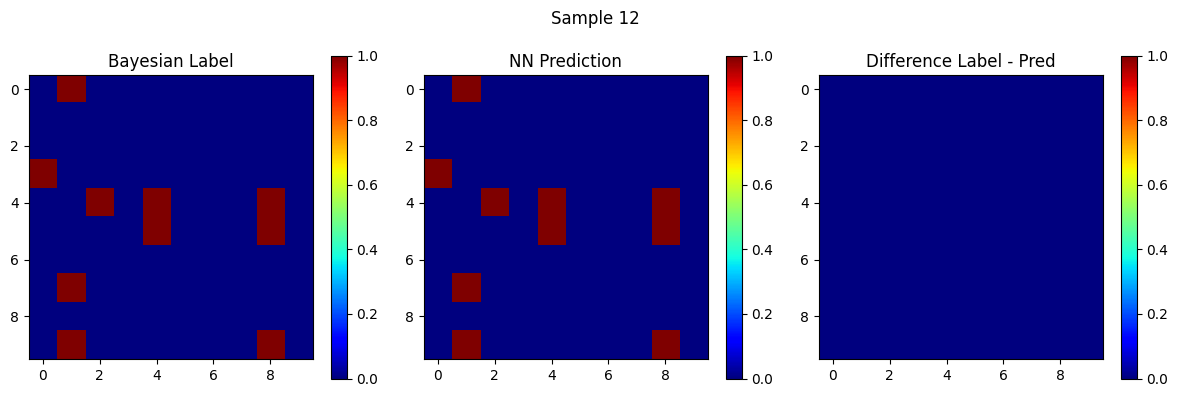

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


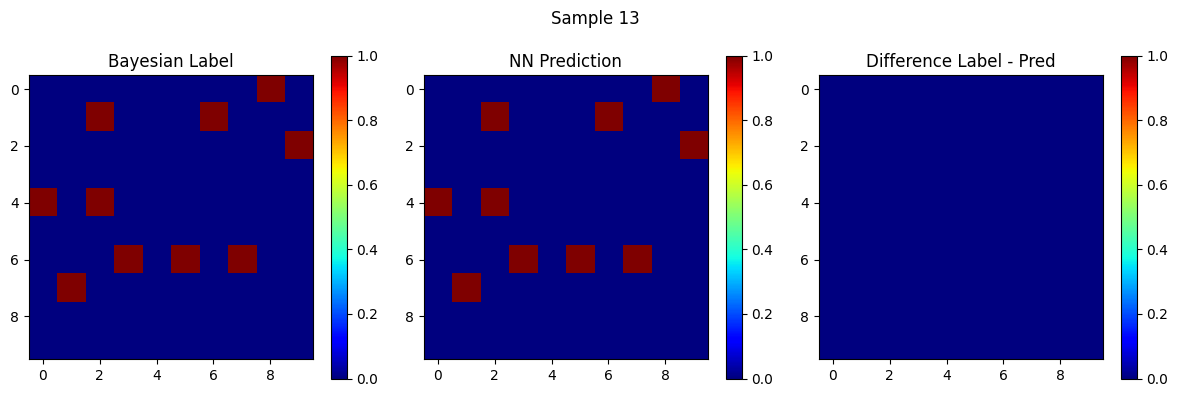

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


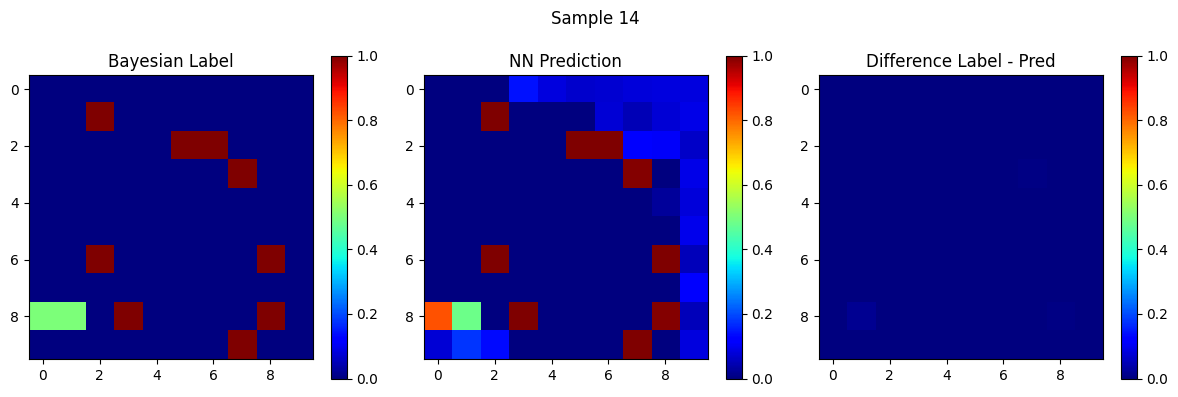

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


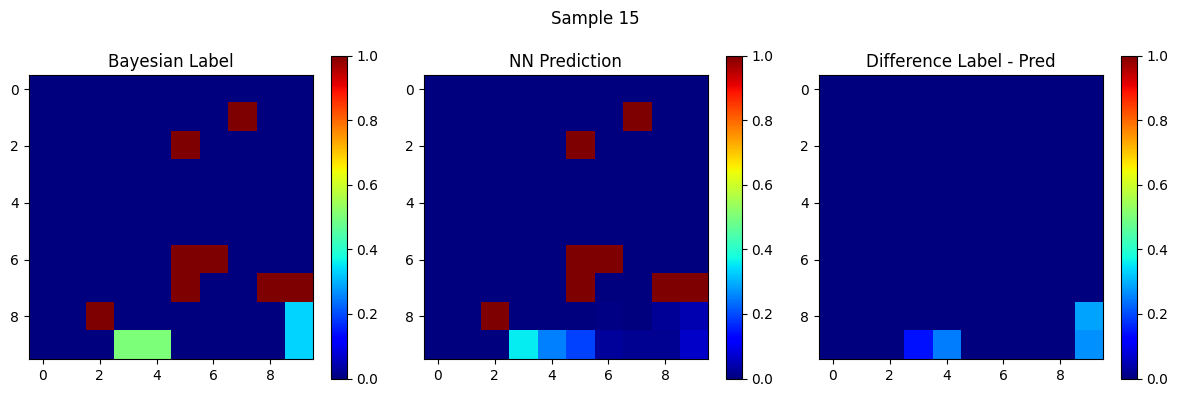

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


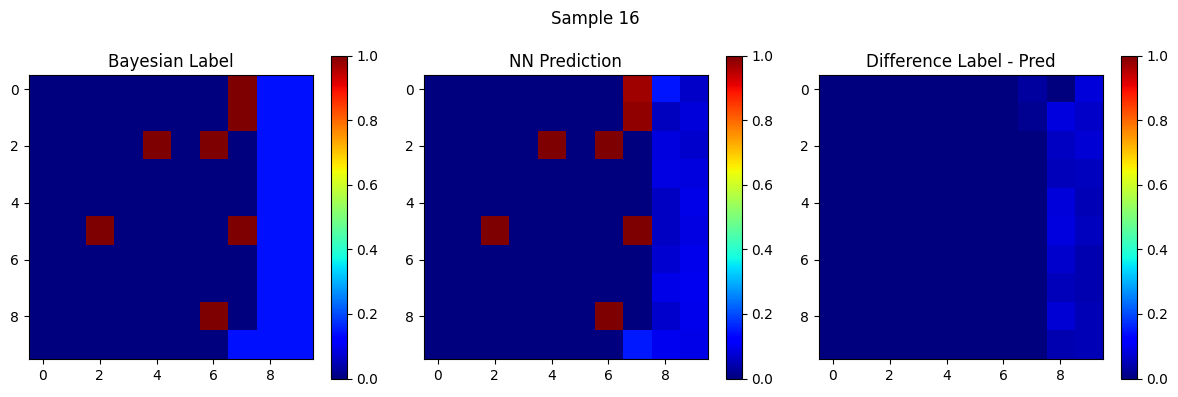

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


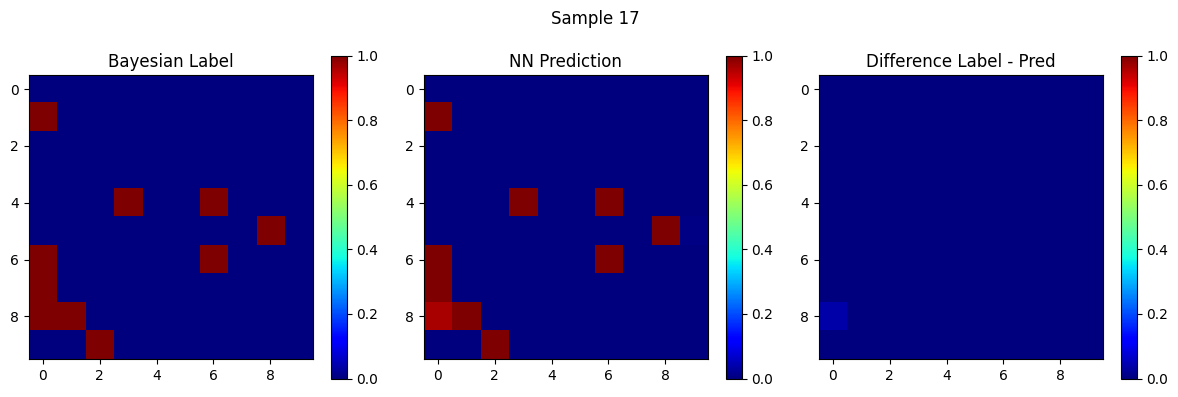

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


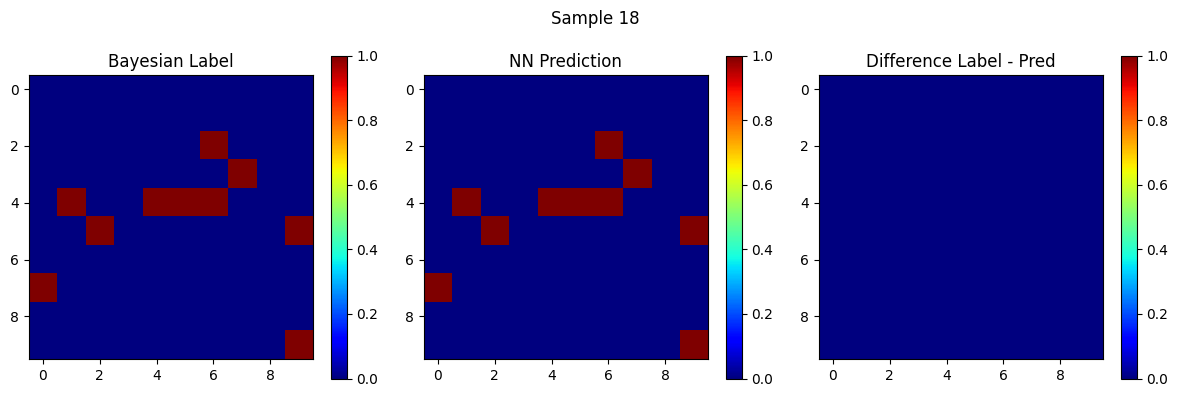

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


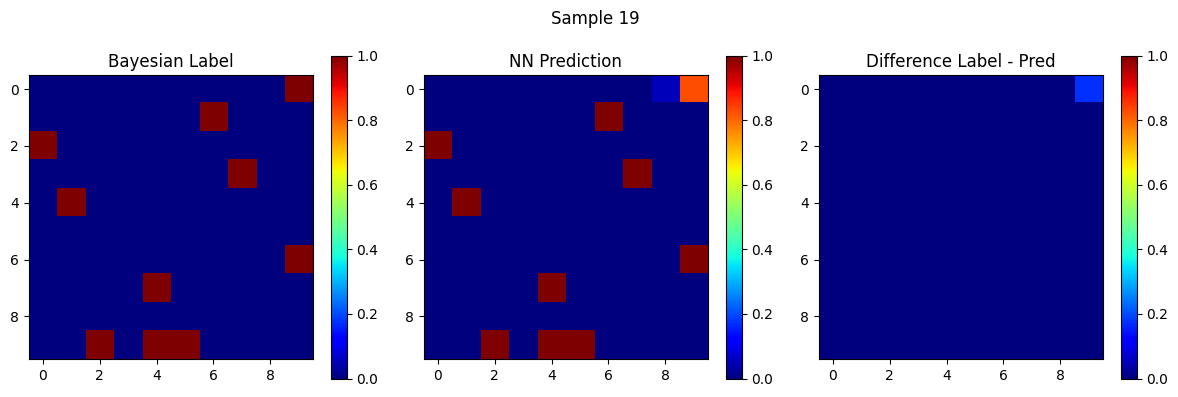

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


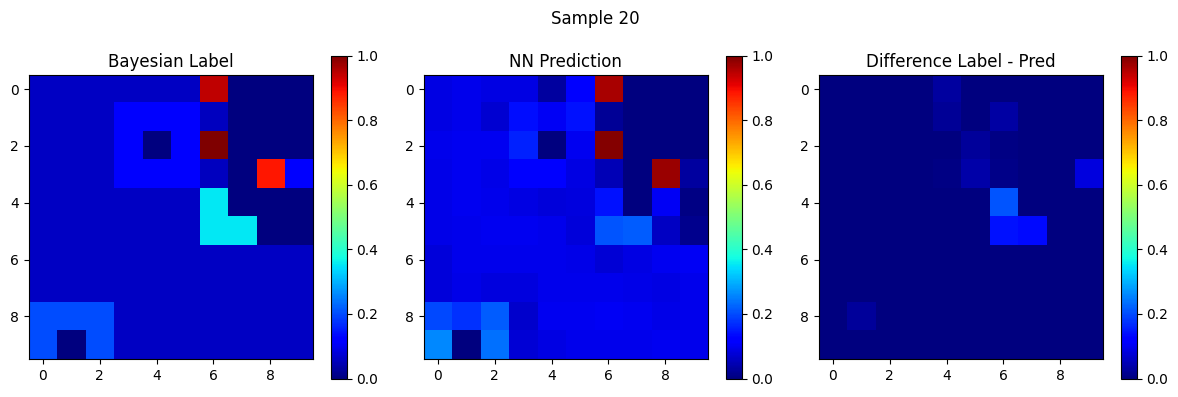

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


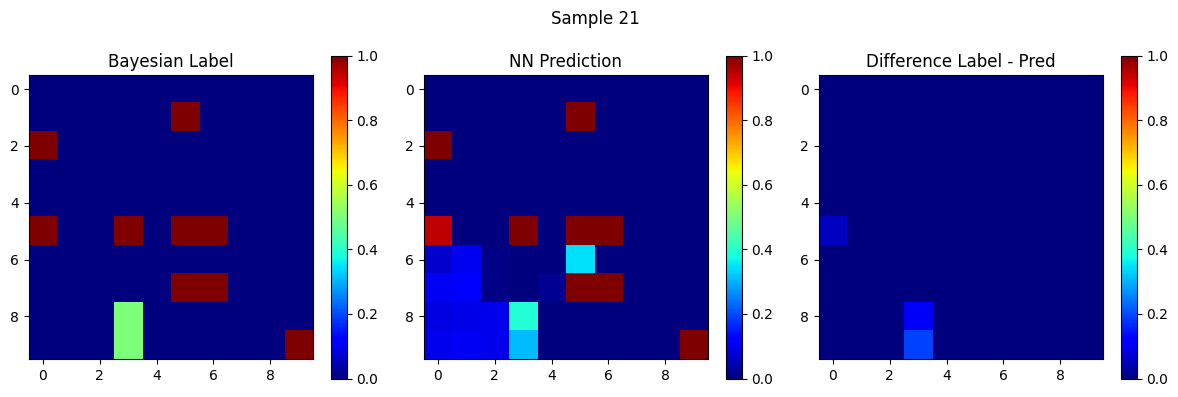

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


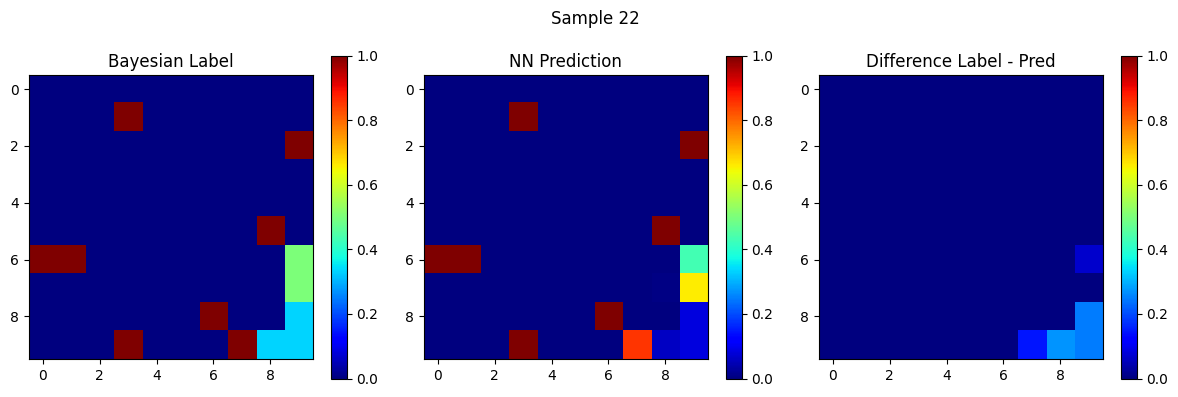

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


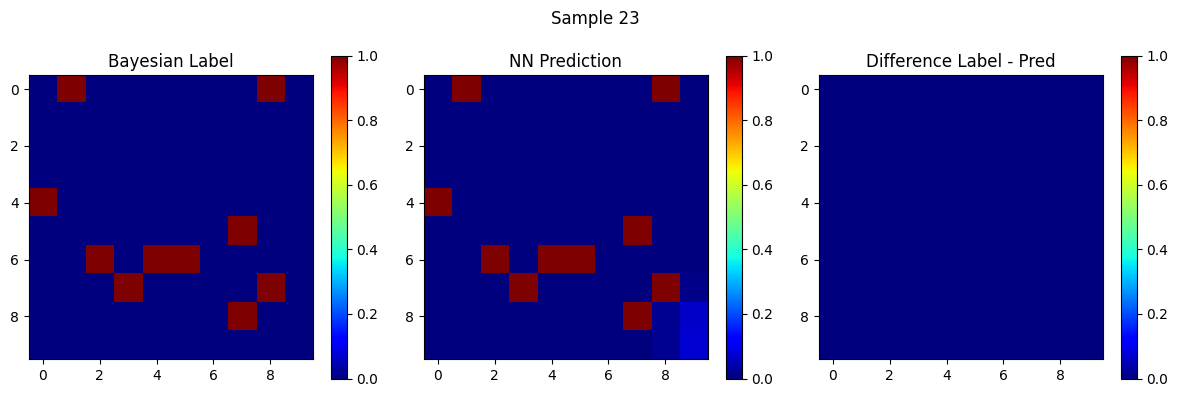

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


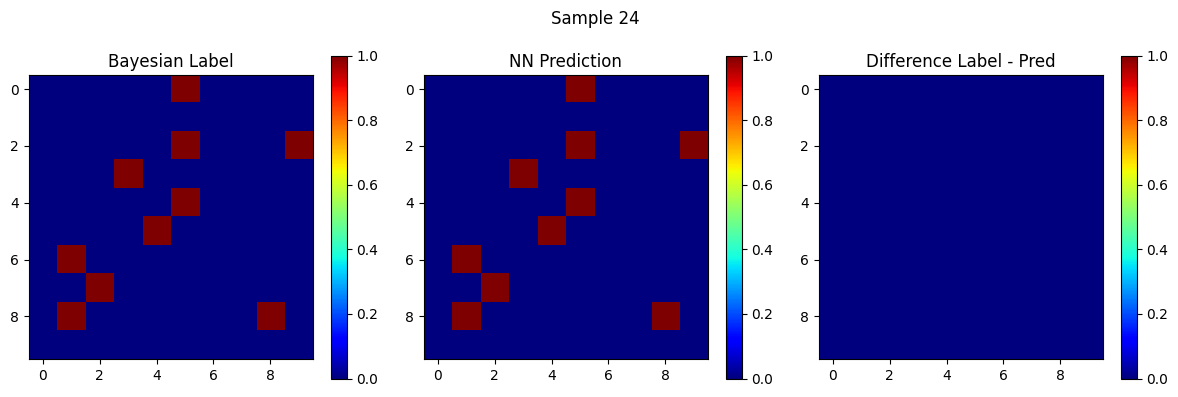

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


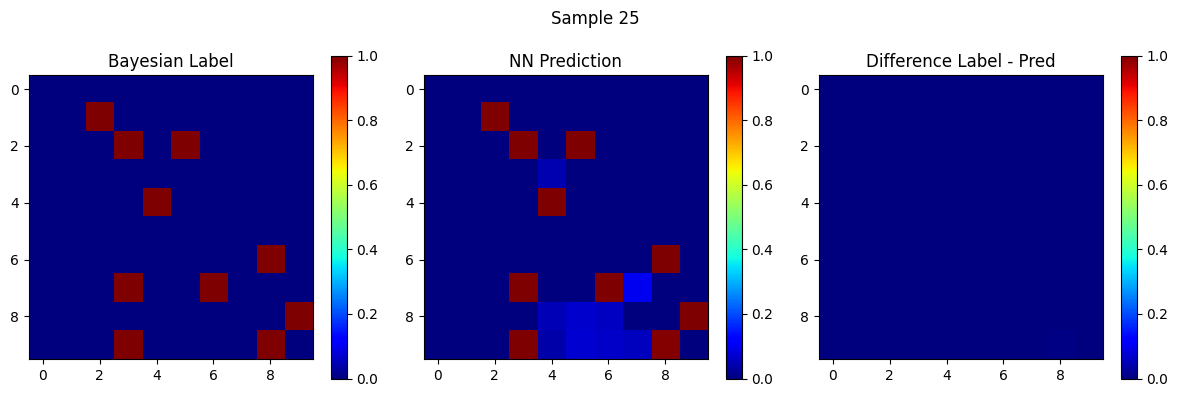

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


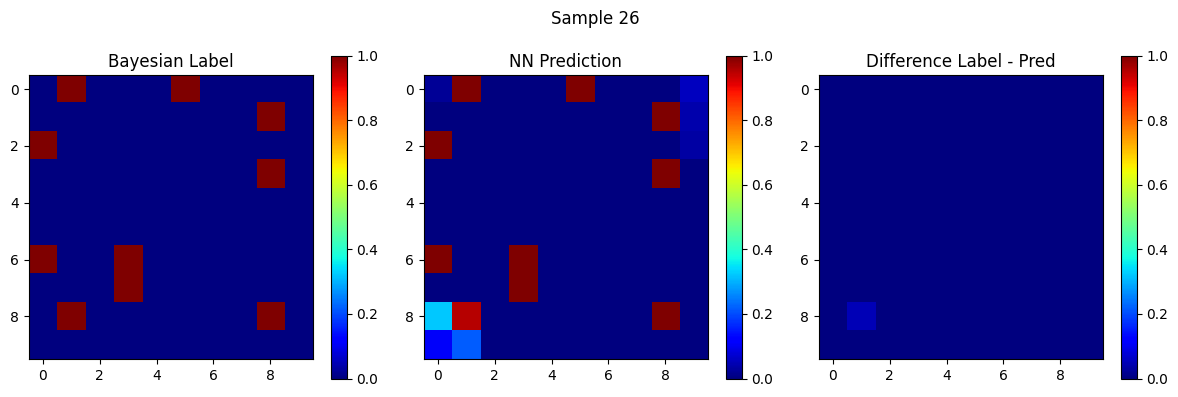

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


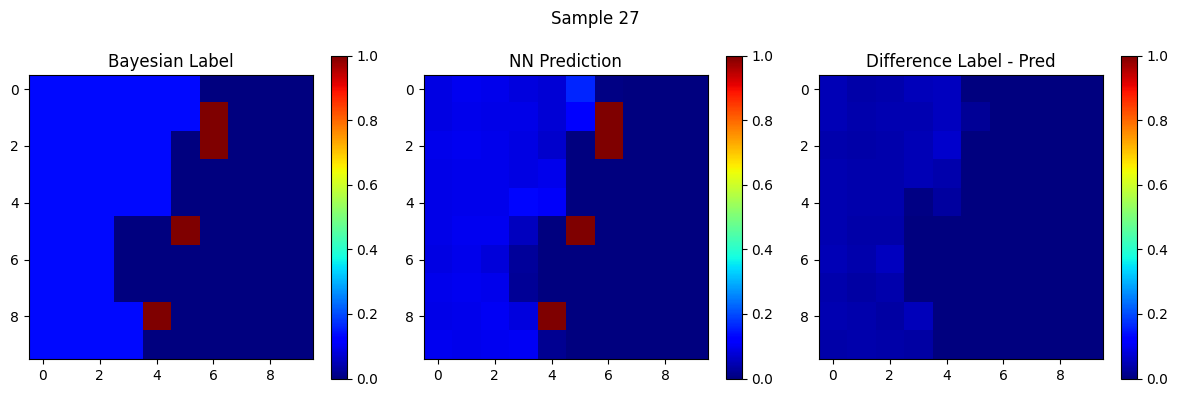

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


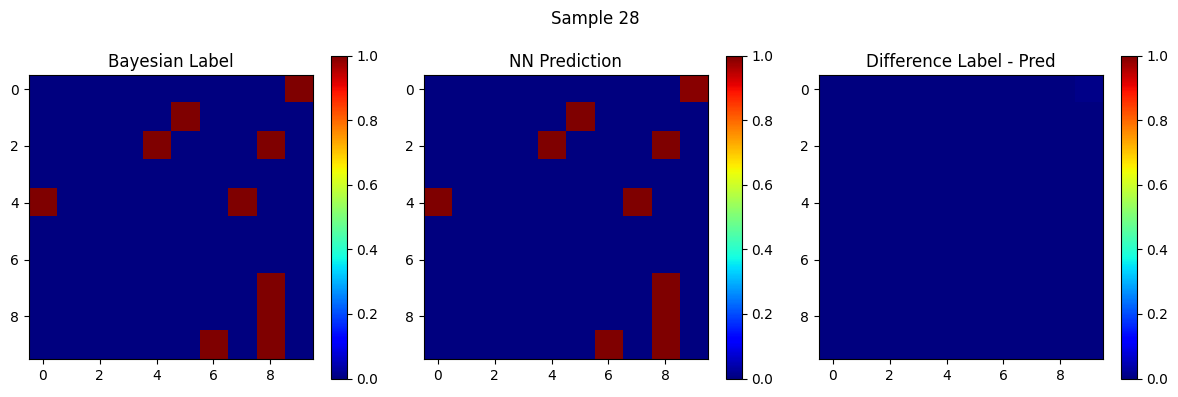

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


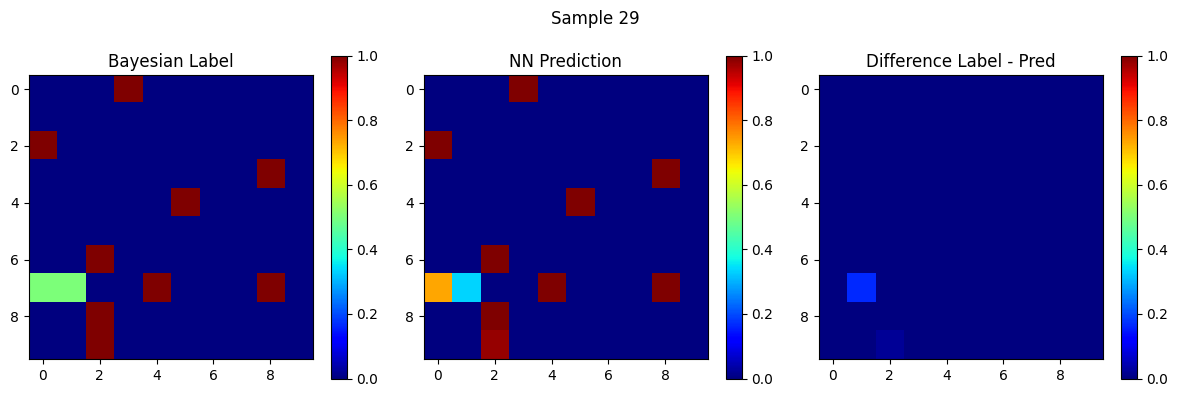

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


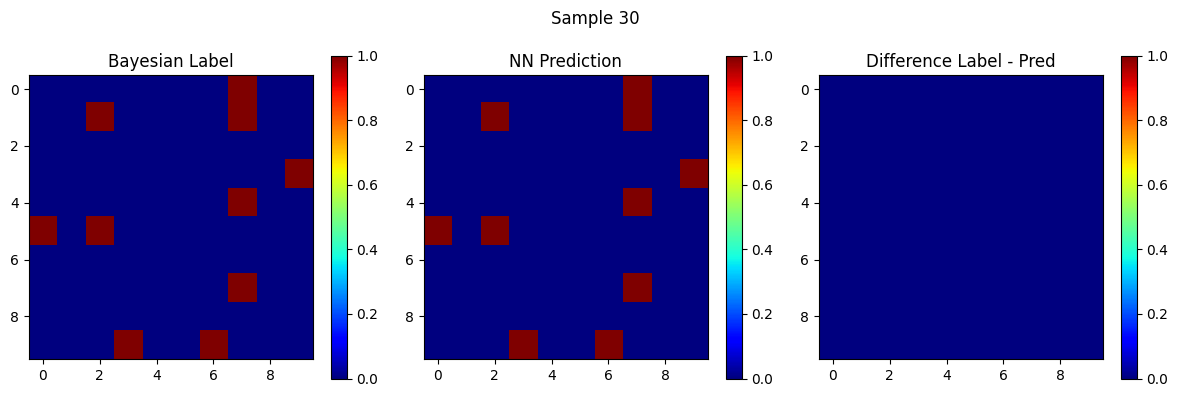

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


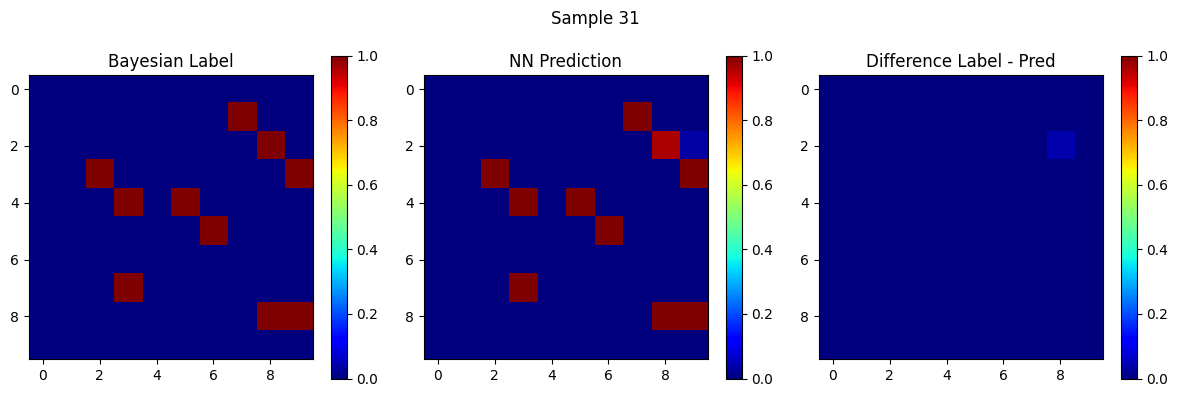

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


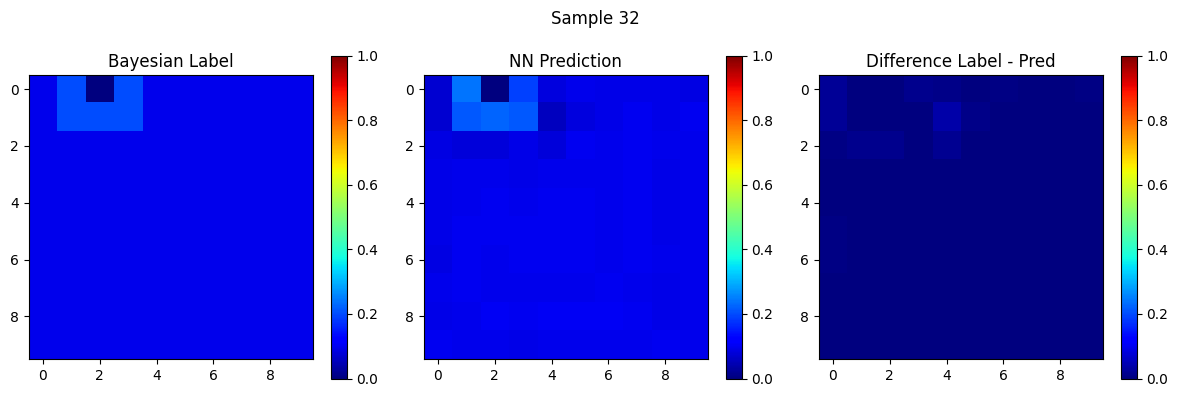

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


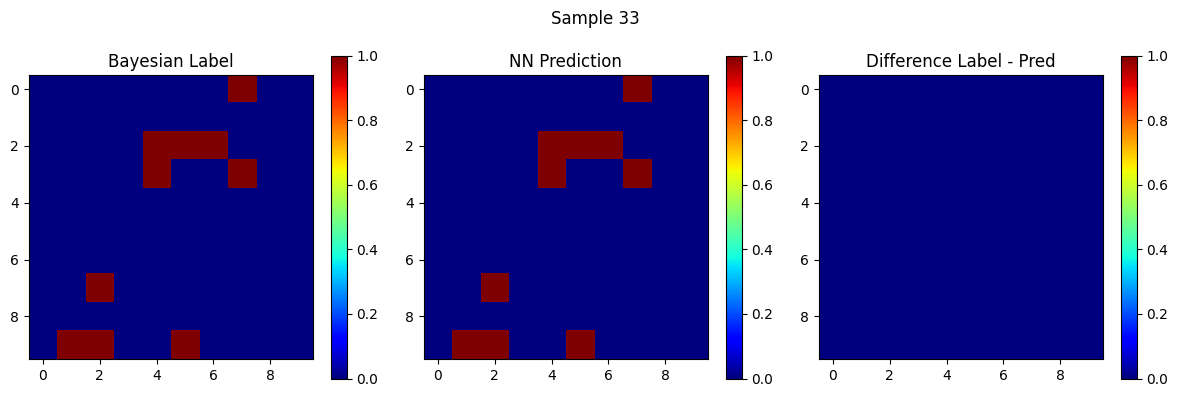

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


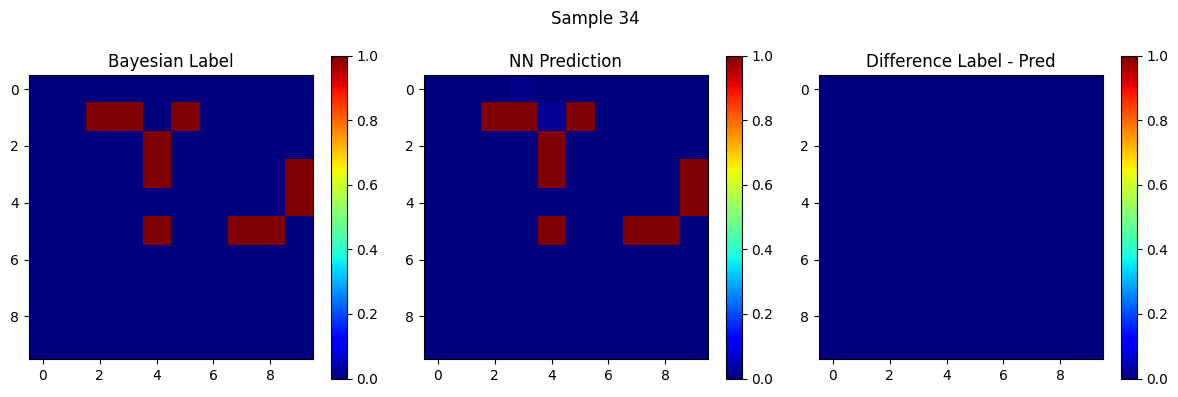

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


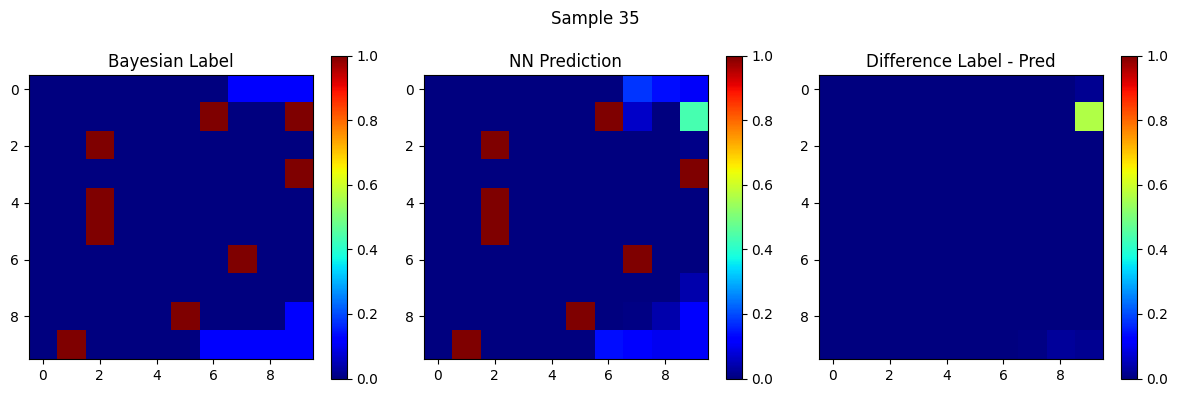

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


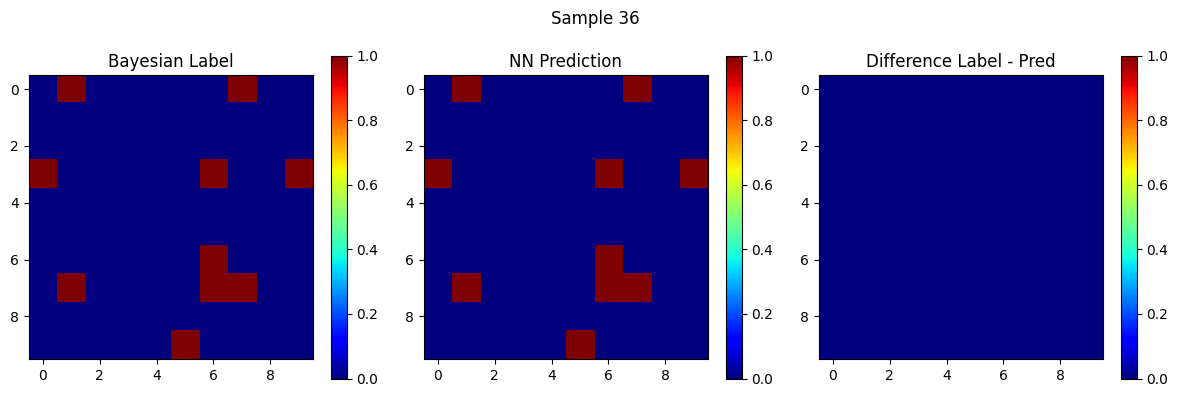

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


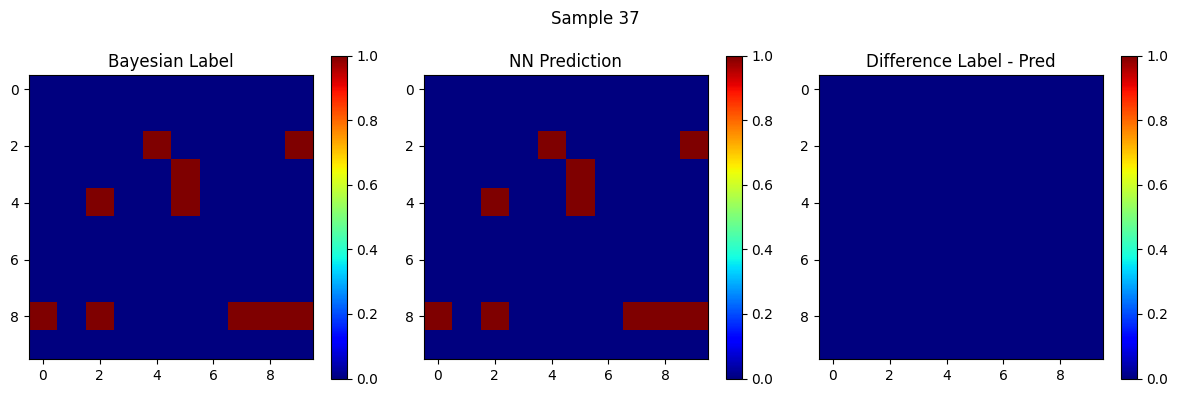

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


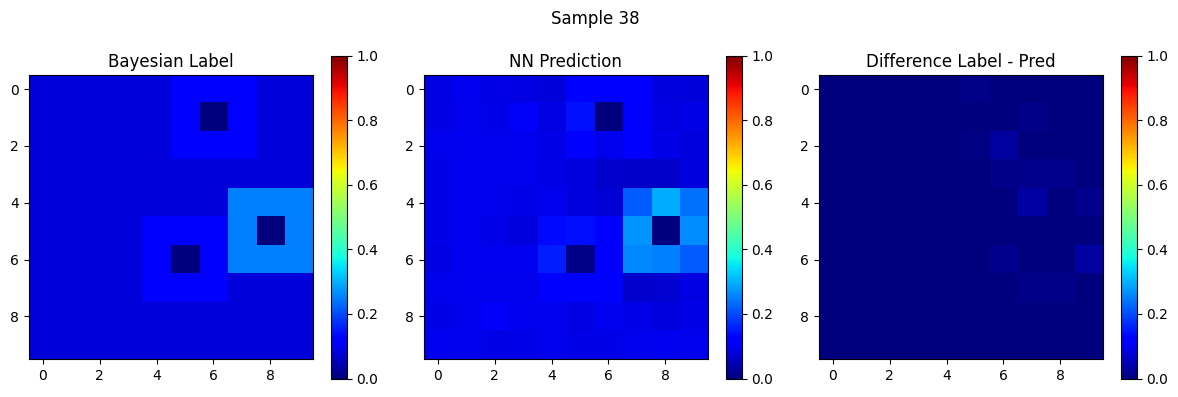

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


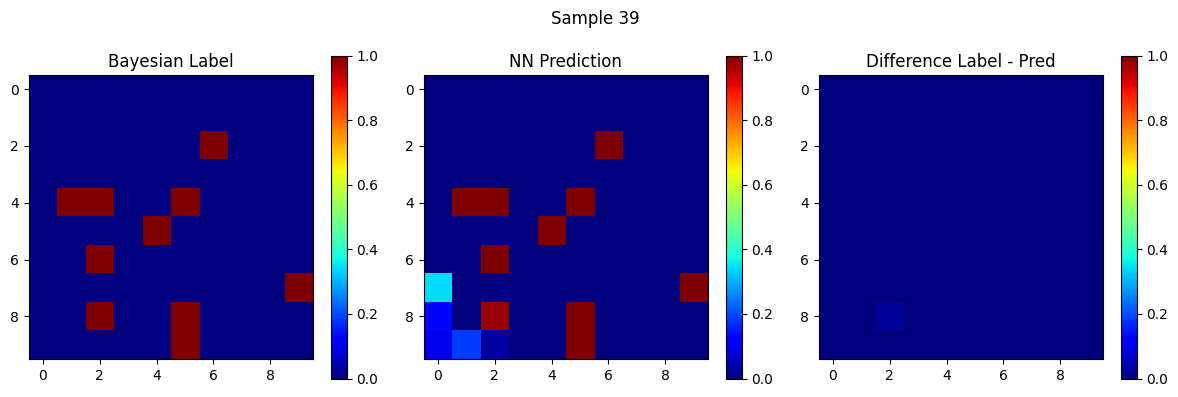

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


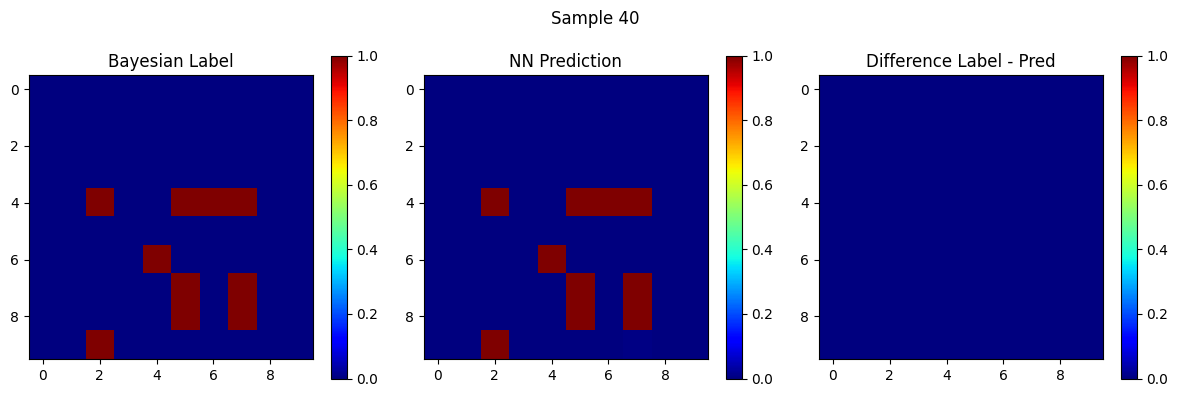

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


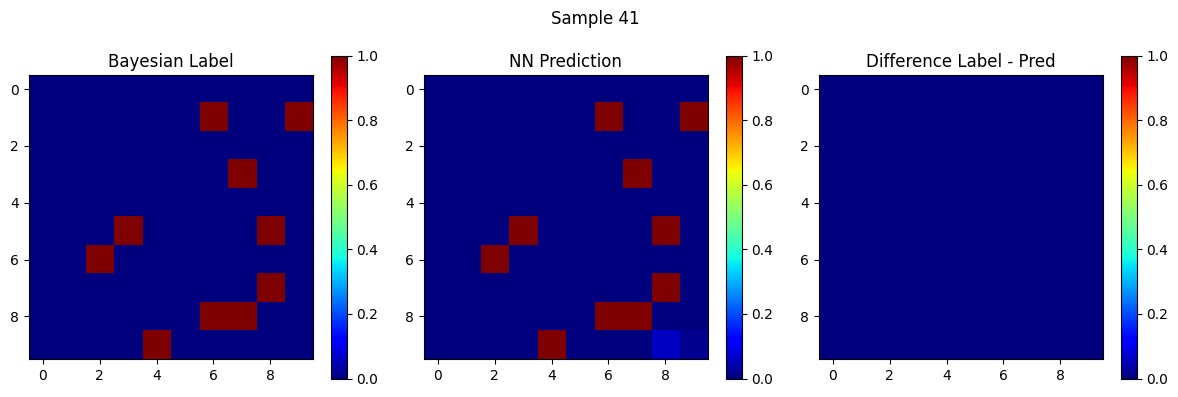

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


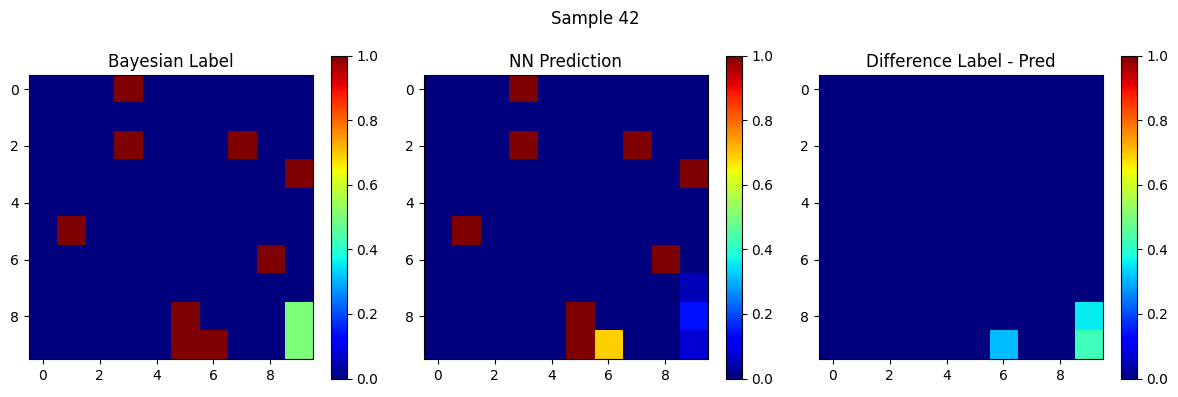

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


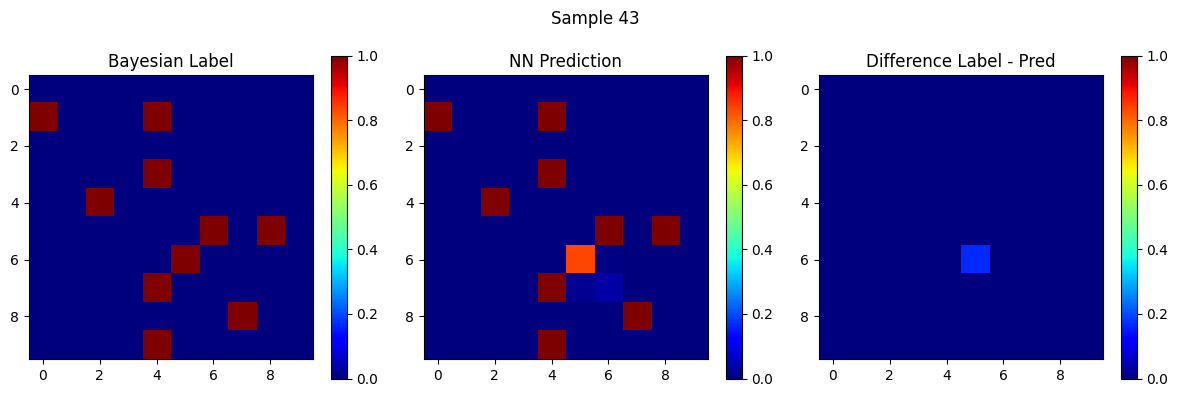

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


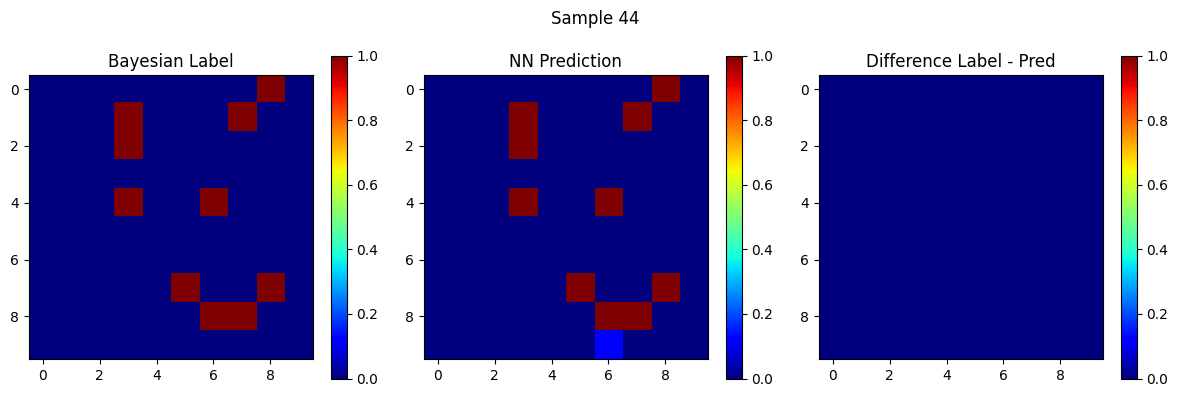

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


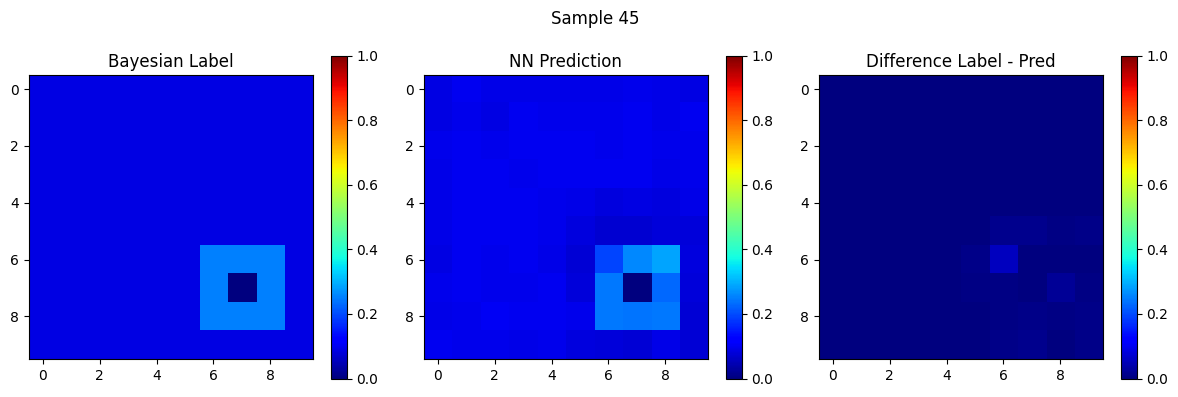

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


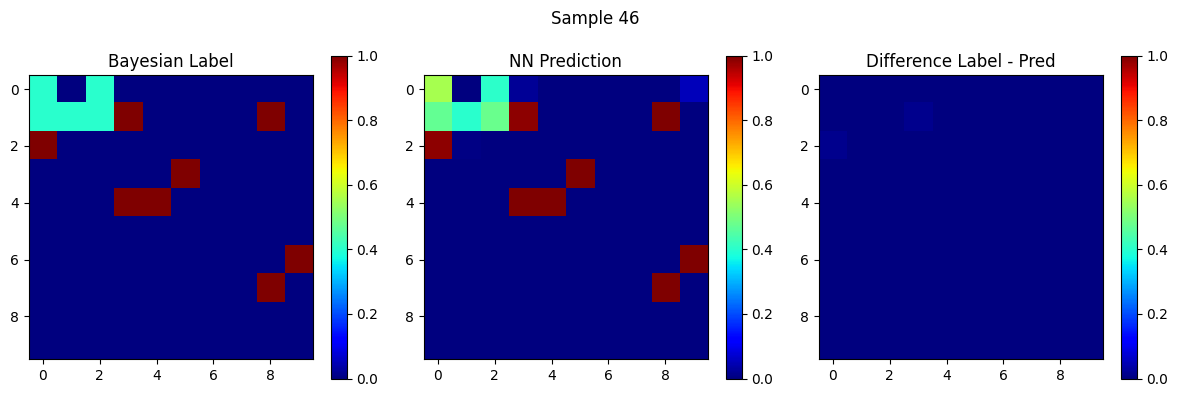

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


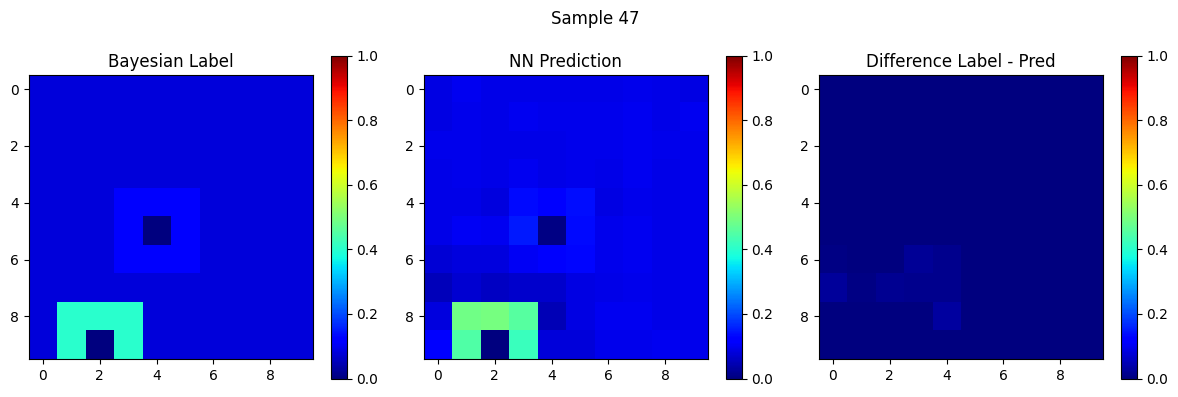

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


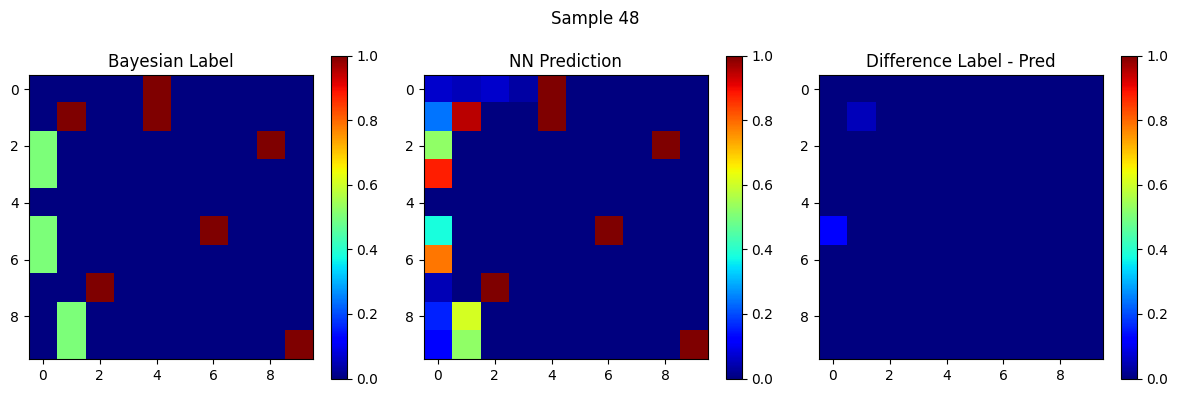

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


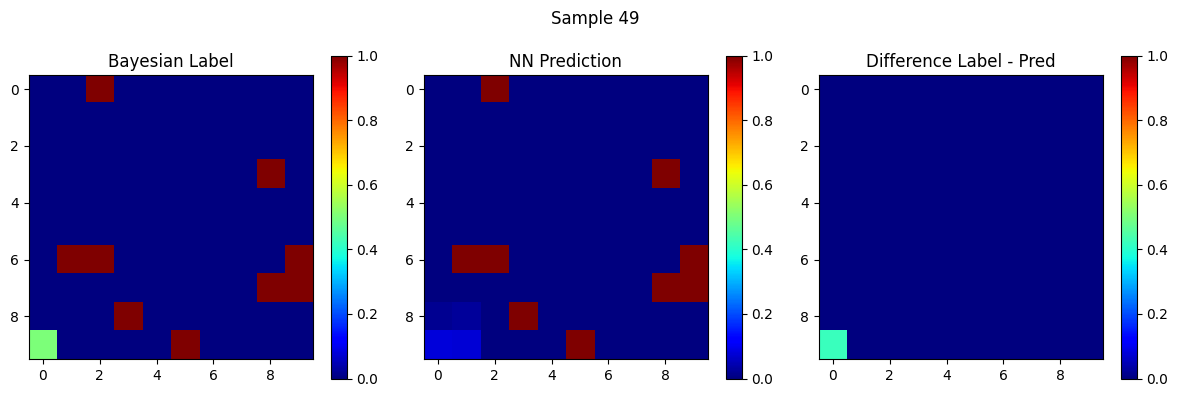

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


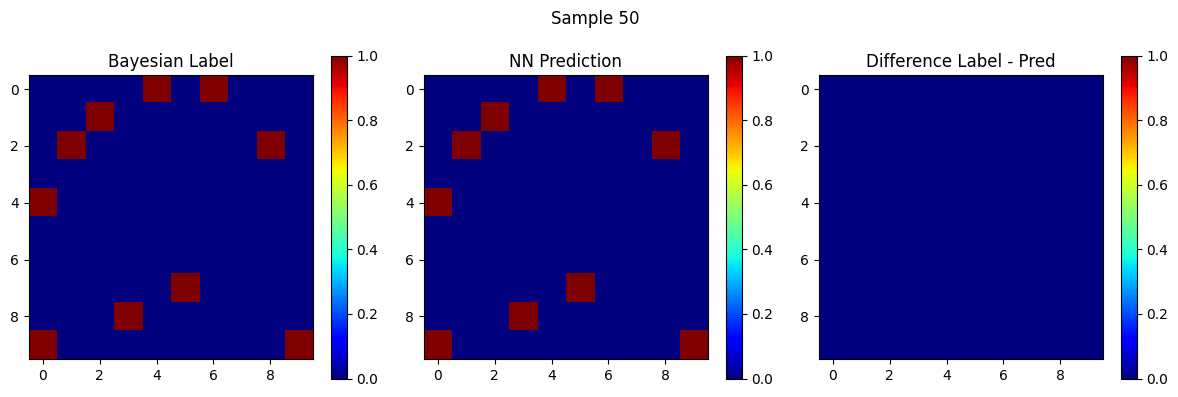

In [52]:
test_samples = list(test_dataset.unbatch().take(50).as_numpy_iterator())

print("\nVisual comparison of Label (Bayes) vs. NN Prediction:")

for i, (board_input, label) in enumerate(test_samples):
    # board_input: shape (N, M, 1)
    # label:       shape (N, M, 1)

    # Add a batch dimension
    board_input_expanded = board_input[np.newaxis, ...]  # shape: (1, N, M, 1)

    # NN Prediction
    prediction = model.predict(board_input_expanded)  # shape: (1, N, M, 1)
    prediction_2d = prediction[0, ..., 0]            # (N, M)
    # prediction_2d[prediction_2d > 0.4] = 1    # Threshholding
    label_2d = label[..., 0]  # shape: (N, M)

    # Difference map:  (Bayesian Label) - (NN Prediction) : Lower estimation is bad -> red
    diff_2d = label_2d - prediction_2d 
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    plt.suptitle(f"Sample {i+1}")

    # 1) Bayesian label
    im1 = axs[0].imshow(label_2d, cmap="jet", vmin=0, vmax=1)
    axs[0].set_title("Bayesian Label")
    fig.colorbar(im1, ax=axs[0])

    # 2) NN prediction
    im2 = axs[1].imshow(prediction_2d, cmap="jet", vmin=0, vmax=1)
    axs[1].set_title("NN Prediction")
    fig.colorbar(im2, ax=axs[1])

    # 3) Difference
    im3 = axs[2].imshow(diff_2d, cmap="jet", vmin=0, vmax=1)
    axs[2].set_title("Difference Label - Pred")
    fig.colorbar(im3, ax=axs[2])

    plt.tight_layout()
    plt.show()